In [1]:
import wisps
import numpy as np
import matplotlib.pyplot as plt
import wisps.simulations as wispsim
import pandas as pd

import seaborn as sns
from matplotlib.colors import Normalize
import astropy.units as u 

%matplotlib inline

In [2]:
import seaborn as sns
import matplotlib

#cmap= sns.color_palette("coolwarm", 8, as_cmap=True)
cmap=matplotlib.cm.get_cmap('coolwarm')
cnorm=Normalize(wispsim.HS[0]/100, (wispsim.HS[-1])/100)

In [239]:
def bin_by_spt_bin(sp_types, number, ltonly=False):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 40]]
    if ltonly:
        ranges=[[20, 30], [30, 41]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers


def get_pointing(grism_id):
    if grism_id.startswith('par'):
        pntname=grism_id.lower().split('-')[0]
    else:
        pntname=grism_id.lower().split('-g141')[0]
    loc=pnt_names.index(pntname)
    return np.array(pnts)[loc]

def iswithin_mag_limits(mags, pnt):
    #mgs is a dictionary
    flags=[]
    for k in pnt.mag_limits.keys():
        if k =='F110' and pnt.survey =='hst3d':
            flags.append(True)
        else:
            flags.append(mags[k] < pnt.mag_limits[k])
    return np.logical_or.reduce(flags)


def plot(NUMBERS, VOLUMES):
    # In[ ]:
    y2=bin_by_spt_bin(wispsim.SPGRID,nobs)
    dy2=np.sqrt(y2)

    fig, ax=plt.subplots(figsize=(12, 12), ncols=2, nrows=2, sharey=True, sharex=False)
    for model, a in zip(['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020'], np.concatenate(ax)):
        
        for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])*VOLUMES[idx]
            
            a.step(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns), 
                         where='mid', label='h={} pc'.format(h), color= cmap(cnorm(h/100)), linewidth=3)
        
        a.set_yscale('log')
        a.errorbar(spgrid2,y2, yerr=dy2,fmt='o', color='k')
        a.set_xlabel('SpT',fontsize=18)
        a.set_ylabel('N',fontsize=18)
        a.minorticks_on()
            


    ax[0][0].set_title('Model= SM08', fontsize=18)
    ax[0][1].set_title('Model= B03', fontsize=18)
    ax[1][0].set_title('Model= M19', fontsize=18)
    ax[1][1].set_title('Model= P20', fontsize=18)

    ax[0][0].errorbar(spgrid2,y2, yerr=dy2,fmt='o', color='k', label='observations')
    ax[0][0].legend(fontsize=14, loc='upper right')
    plt.tight_layout()
    plt.savefig(wisps.OUTPUT_FIGURES+'/oberved_numbers.pdf', bbox_inches='tight')

In [4]:
sgrid=wispsim.SPGRID
pnts=wisps.OBSERVED_POINTINGS

In [5]:
cands=pd.read_pickle(wisps.LIBRARIES+'/candidates.pkl')
cands=cands[(cands.spt >=17) & (cands.snr1>=3)].reset_index(drop=True)
tab=wisps.Annotator.reformat_table(cands)
pnt_names=[x.name for x in pnts]

In [6]:
tab['pnt']=tab['grism_id'].apply(get_pointing)
tab['spt_val']=np.vstack(tab.spt.values)[:,0]
obsmgs=tab[['F140W', 'F110W', 'F160W']].rename(columns={"F110W": "F110", 
                                                                    "F140W": "F140",
                                                                    "F160W": "F160"}).to_dict('records')
flags=[iswithin_mag_limits(x, y) for x, y in zip(obsmgs, tab.pnt.values)]

cdf_to_use=tab[flags]
nobs=wisps.custom_histogram(cdf_to_use.spt_val.apply(wisps.make_spt_number), sgrid, 1)

spgrid2=['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']

In [7]:
NUMBERS=pd.read_pickle(wisps.OUTPUT_FILES+'/numbers_simulated.pkl.gz')

In [8]:
volumes=[]
for pnt in pnts:
    vs=[]
    for h in wispsim.HS:
        vsx=[]
        for g in wispsim.SPGRID:
            vsx.append((pnt.volumes[h])[g])
        vs.append(vsx)
    volumes.append(vs)
volumes=np.array(volumes)

VOLUMES=np.nansum(volumes, axis=0)*4.1*(u.arcmin**2).to(u.radian**2)

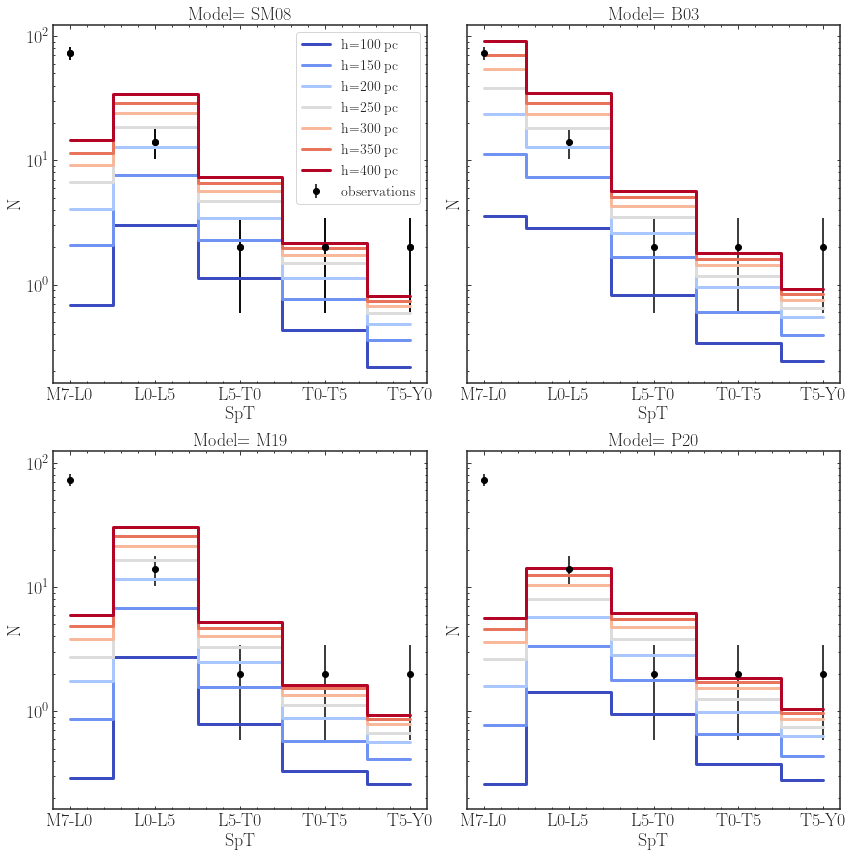

In [9]:
 plot(NUMBERS, VOLUMES)

In [240]:
y2=bin_by_spt_bin(wispsim.SPGRID,nobs)

In [241]:
y2

[73, 14, 2, 2, 2]

In [242]:
#just for L dwarfs and T dwarfs
y3=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=True)

In [243]:
y3

[16, 4]

In [245]:
y4=np.append(y2, y3)

In [247]:
#PRINT THE BEST FIT NUMBER 
#best_fit={}
numbers_fit={}
for model in ['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020']:
        model_fit={}
        model_number={}
        for idx, h in enumerate(wispsim.HS):
            ns=None
            ns=np.array(((NUMBERS[model])[idx])*VOLUMES[idx])
            binned=np.array(bin_by_spt_bin(wispsim.SPGRID,ns))
            
            binned_lt=np.array(bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=True))
            #add L and 
            #compute chi-squared
            #print (ns)
            #chisq= abs((y2-binned)**2/(y2))
            #model_fit.update({h: chisq})
            binned_total=np.append(binned, binned_lt)
            model_number.update({h: binned_total})
        # best_fit.update({model: model_fit})
        numbers_fit.update({model: model_number})

In [248]:
chisq_dicts=pd.DataFrame.from_records(best_fit)
number_dicts=pd.DataFrame.from_records(numbers_fit)

In [264]:
brfsm=np.vstack(number_dicts['saumon2008'].values)[:,-1]

In [265]:
from scipy.interpolate import interp1d

Text(0.5, 0, 'N')

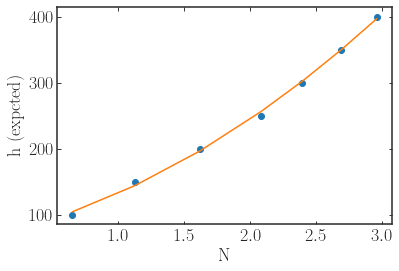

In [266]:
plt.plot(brfsm, wispsim.HS, 'o')
interpf =np.poly1d(np.polyfit(brfsm, wispsim.HS,2))
plt.plot(brfsm, interpf(brfsm))
plt.ylabel('h (expcted)', fontsize=18)
plt.xlabel('N', fontsize=18)

In [252]:
#draw a posson based on nobs
npoisson= np.random.poisson(y2[-1], 100000).astype(float)
npoisson=npoisson[np.logical_and(npoisson>=brfsm7[0], npoisson <=brfsm7[-1])]

In [253]:
np.nanmean(interpf(npoisson)), np.nanstd(interpf(npoisson))

(553.3773359492477, 2.2737367544323206e-13)

In [254]:
spgrid2

['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']

In [300]:
min_chi_ssqrs={}
for c in number_dicts.columns:
    min_vals={}
    #for idx,s  in enumerate(np.append(spgrid2, ['L dwarfs', 'T dwarfs'])):
    for idx,s  in enumerate(spgrid2):
        #compare between subtypes
        #predicted
        vals=(np.vstack(number_dicts[c].values))[:,idx]
        #observed
        nreal= y2[idx]
        #make an interpolation function
        interpf = interp1d(vals, wispsim.HS)
        #using a 2nd degree polynomial 
        #draw a bunch of random values based on a poisson distribution
        npoisson=np.random.poisson(nreal, 100000).astype(float)
        #stay within the range of possible values to avoid interpolation error
        #i.e take this as a prior
        npoisson=npoisson[np.logical_and(npoisson>=vals[0], npoisson <=vals[-1])]
        #predict scale heights
        predhs=interpf(npoisson)
        #use a weighted mean and std 
        mean, unc= (np.nanmean(predhs), np.nanstd(predhs))
        
        min_vals.update({s:[np.round(mean), np.round(unc, 4)]})
        #final minimal
        print (' scale height for model {} and spt {} is {} +/- {} '.format(c, s, np.round(mean), np.round(unc, 4)))
        
    min_chi_ssqrs.update({c:min_vals})
    

 scale height for model baraffe2003 and spt M7-L0 is 353.0 +/- 22.1657 
 scale height for model baraffe2003 and spt L0-L5 is 210.0 +/- 34.1617 
 scale height for model baraffe2003 and spt L5-T0 is 181.0 +/- 65.6149 
 scale height for model baraffe2003 and spt T0-T5 is 211.0 +/- 0.0 
 scale height for model baraffe2003 and spt T5-Y0 is nan +/- nan 
 scale height for model marley2019 and spt M7-L0 is nan +/- nan 
 scale height for model marley2019 and spt L0-L5 is 224.0 +/- 38.7432 
 scale height for model marley2019 and spt L5-T0 is 189.0 +/- 71.4278 
 scale height for model marley2019 and spt T0-T5 is 223.0 +/- 0.0 
 scale height for model marley2019 and spt T5-Y0 is nan +/- nan 
 scale height for model phillips2020 and spt M7-L0 is nan +/- nan 
 scale height for model phillips2020 and spt L0-L5 is 329.0 +/- 50.8304 
 scale height for model phillips2020 and spt L5-T0 is 172.0 +/- 64.6101 
 scale height for model phillips2020 and spt T0-T5 is 203.0 +/- 0.0 
 scale height for model phill

In [301]:
pd.DataFrame(min_chi_ssqrs)

,baraffe2003,marley2019,phillips2020,saumon2008
M7-L0,"[353.0, 22.1657]","[nan, nan]","[nan, nan]","[nan, nan]"
L0-L5,"[210.0, 34.1617]","[224.0, 38.7432]","[329.0, 50.8304]","[209.0, 33.8648]"
L5-T0,"[181.0, 65.6149]","[189.0, 71.4278]","[172.0, 64.6101]","[177.0, 46.3519]"
T0-T5,"[211.0, 0.0]","[223.0, 0.0]","[203.0, 0.0]","[272.0, 90.1766]"
T5-Y0,"[nan, nan]","[nan, nan]","[376.0, 0.0]","[nan, nan]"


In [302]:
def propagate_uncertainties(row):
    vals=np.vstack(row.values)[:,0]
    uncs=np.vstack(row.values)[:,1]
    
    return round(np.nanmean(vals)), round(np.sqrt(np.nansum(uncs**2)))

In [303]:
pd.DataFrame(min_chi_ssqrs).apply(propagate_uncertainties, axis=1)

M7-L0     (353, 22)
L0-L5     (243, 80)
L5-T0    (180, 125)
T0-T5     (227, 90)
T5-Y0      (376, 0)
dtype: object

In [304]:
(376+227)/2

301.5

In [305]:
#use my velocity dispersion converter 
def velocity_dispersion(h, hunc):
    #do a monte carlo uncertainty prop
    hs= np.random.normal(h, hunc, 10000)
    vals=np.sqrt((hs*68)/217*20)

    return np.nanmean(vals), np.nanstd(vals)
    
vel_tables=pd.DataFrame(min_chi_ssqrs).apply(propagate_uncertainties, axis=1).apply(lambda x: velocity_dispersion(x[0], x[1]))

In [306]:
brfvls=pd.DataFrame(min_chi_ssqrs).baraffe2003.iloc[0]

In [307]:
vel_tables['M7-L0']=velocity_dispersion(brfvls[0], brfvls[1])

In [308]:
#do monte carlo uncertainty propagation
def get_age(sigma, sigmaunc, beta, tau1, sigma10):
    sigmas=np.random.normal(sigma, sigmaunc, 10000)
    vals=((sigmas/sigma10)**(1/beta))*(10+tau1)-tau1
    return np.nanmean(vals), np.nanstd(vals)

In [309]:
age_tables= vel_tables.apply(lambda x: get_age(x[0], x[1], 0.385, 0.261, 57.157))
age_tables=age_tables.apply(lambda x:np.array(x)).apply(lambda x: np.round(x, 1))

In [310]:
age_emp=pd.DataFrame()
age_emp['subtype']=np.array(age_tables.index)
age_emp['age']=np.vstack(age_tables.values)[:,0]
age_emp['unc']=np.vstack(age_tables.values)[:,1]

In [311]:
vel_tables

M7-L0         (47.01137292919217, 1.4668271899744005)
L0-L5         (38.469962363787246, 6.856670722002436)
L5-T0        (33.708007198605905, 10.498682103879522)
T0-T5          (36.99438463548936, 7.838663770320338)
T5-Y0    (48.543770927406705, 1.4210854715202004e-14)
dtype: object

In [312]:
#do a global scale height
#convert velocity dispersion to age using emprical relations
#compare this to the median age of the population 

In [321]:
#binning class 
def istoldwarf(x):
    if np.logical_or(x >=17, x<20):
        return 'M dwarfs'
    elif np.logical_or(x >=20, x<30):
        return 'L dwarfs'
    elif np.logical_or(x >=30,  x<40):
        return 'T dwarfs'
    else: 
        return ''

In [322]:
#plot age with scale heights
age_dictionaries={}
for model in ['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020']:
    dfs=[]
    for hidx in wispsim.HS:
        dfs.append(pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample.hdf', key=str(model)+str('h')+str(hidx)))
        
    df=pd.concat(dfs)
    print (len(df))
    cutdf_lblded=wisps.Annotator.group_by_spt(df, spt_label='spt', assign_number=False).rename(columns={'spt_range': 'subtype'})
    cutdf_lblded['spectclass']=  cutdf_lblded.spt.apply(lambda x: istoldwarf(x))
    final_df=cutdf_lblded[~((cutdf_lblded.spectclass=='') | (cutdf_lblded.subtype=='')|   (cutdf_lblded.subtype=='trash'))]
    age_dictionaries[model]=final_df

982178
1060630
972469
381757


In [315]:
#change the tdwarf uncertainty
age_emp.unc.loc[4]=1.

In [325]:
dfn[dfn.spectclass=='L dwarfs']

,spt,teff,age,slprob,snr,appF140,appF110,appF160,pntname,dist,pnt,subtype,data_type,spectclass


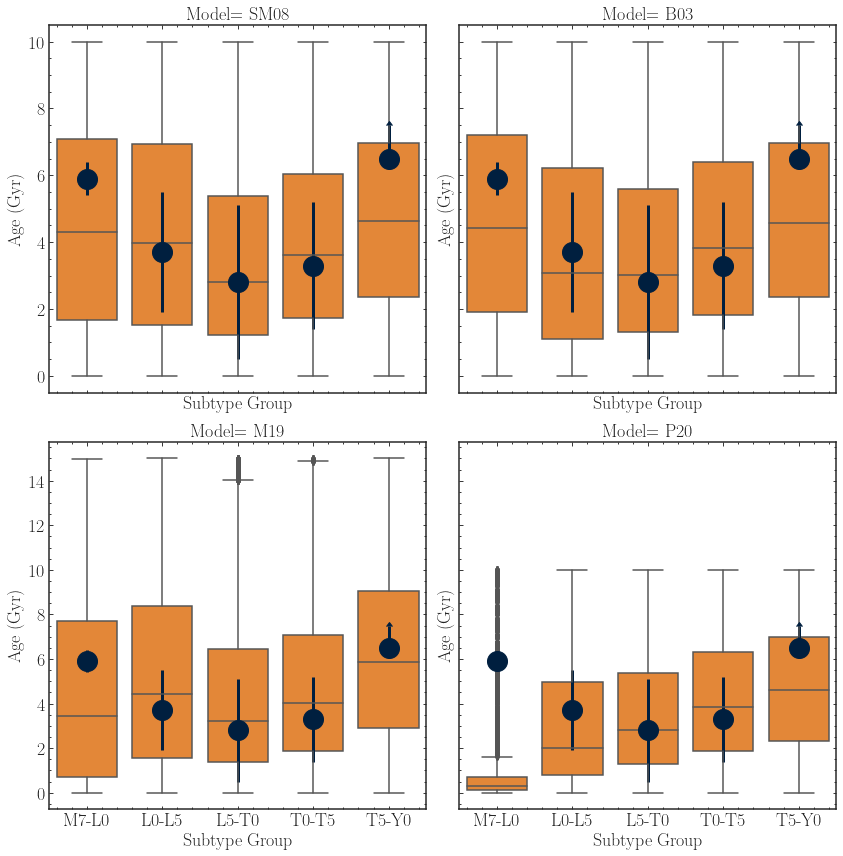

In [324]:

fig, ax=plt.subplots(figsize=(12, 12), ncols=2, nrows=2, sharex=True, sharey='row')

for model, a in zip(['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020'], np.concatenate(ax)):
    
    dfn=age_dictionaries[model].replace('T5-T9', 'T5-Y0')
    #change T5-T9 to T5-Y0

    sns.boxplot(y=dfn.age.values*dfn.slprob, x=dfn.subtype, ax=a,
                color='#FF851B', order=['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0'])
    
    #sns.boxplot(y=dfn.age.values*dfn.slprob, x=dfn.spectclass, ax=a,
    #            color='#FF851B')
    
    #upper and low limit of the error
    lolims = np.array([0, 0, 0, 0,1], dtype=bool)
    
    a.errorbar(age_emp.subtype,  age_emp.age, yerr=age_emp.unc, color='#001f3f', fmt='o',lolims=lolims, ms=20, lw=3)
    
    a.set_xlabel('Subtype Group', fontsize=18)
    a.set_ylabel('Age (Gyr)', fontsize=18)
    a.minorticks_on()

ax[0][0].set_title('Model= SM08', fontsize=18)
ax[0][1].set_title('Model= B03', fontsize=18)
ax[1][0].set_title('Model= M19', fontsize=18)
ax[1][1].set_title('Model= P20', fontsize=18)

plt.tight_layout()


plt.savefig(wisps.OUTPUT_FIGURES+'/age_comparison.pdf', bbox_inches='tight')
